SHGO - Simplicial HOmological Global Optimisation
=================================================

Knowledge 
- https://stefan-endres.github.io/shgo/

Basic example with rosenbrock
-----------------------------

In [3]:
from scipy.optimize import rosen, shgo
bounds = [(0,2), (0, 2)]
result = shgo(rosen, bounds)
result.x, result.fun


(array([1., 1.]), 3.658411273465293e-19)

In [4]:
import sys
sys.path.insert(0, '../')
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import shgo, minimize, Bounds
from scipy.interpolate import interp1d

from silentsub.device import StimulationDevice
from silentsub.plotting import stim_plot
from silentsub.CIE import get_CIES026

sns.set_context('notebook')
sns.set_style('whitegrid')


Load the data with `StimulationDevice`
--------------------------------------

In [5]:
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led','intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))

# list of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

# instantiate the class
device = StimulationDevice(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1)

Define optimisation problem
---------------------------

This is the 'basic' optimisation where we aim to maximise melanopic contrast whilst keeping cone contrast at zero.

In [6]:
class OptimisationProblem:
    def __init__(self, aopic):
        self.aopic = aopic

    def smlri_calculator(self, weights):
        '''Calculates a-opic irradiance for the given weights.
        The first 10 values in weights define the background
        spectrum and the second 10 values define the modulation'''
        background = weights[0:10]
        modulation = weights[10:20]
        bg_smlri = 0
        mod_smlri = 0
        for led in range(10):
            x = self.aopic.loc[led].index / 4095
            y = self.aopic.loc[led]
            f = interp1d(x, y, axis=0, fill_value='extrapolate')
            bg_smlri += f(background[led])
            mod_smlri += f(modulation[led])
        return (pd.Series(bg_smlri, index=self.aopic.columns, name='Background'),
                pd.Series(mod_smlri, index=self.aopic.columns, name='Modulation'))

    def objective_function(self, weights):
        '''Calculates negative melanopsin contrast for background
        and modulation spectra. We want to minimise this.'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = (mod_smlri.I-bg_smlri.I) / bg_smlri.I
        return -contrast

    def cone_contrast_constraint_function(self, weights):
        '''Calculates S-, M-, and L-opic contrast for background
        and modulation spectra. We want to this to be zero'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = np.array([(mod_smlri.S-bg_smlri.S) / bg_smlri.S,
                             (mod_smlri.M-bg_smlri.M) / bg_smlri.M,
                             (mod_smlri.L-bg_smlri.L) / bg_smlri.L])
        return contrast

    def weights_to_settings(self, weights):
        '''Turns weights to 12-bit STLAB settings.'''
        return ([int(val*4095) for val in weights[0:10]],
                [int(val*4095) for val in weights[10:20]])

Do optimisation
---------------

In [10]:
# A random starting point for the optimisation
# x0 = np.random.rand(1, 20)[0] # don't think we need this

op = OptimisationProblem(device.aopic)

constraints = ({
    'type': 'eq',
    'fun': lambda x: op.cone_contrast_constraint_function(x)
})

# The bounds should be between 0-1, otherwise we are outside the
# gamut of the device
bounds = [(0, 1.),] * 20

# Plotting func

# Callback function to give info on all minima found and
# call off the search when we hit a target melanopic contrast
def print_fun(xk):
    print(xk)

minimizer_kwargs = {
    'method': 'SLSQP',
    'bounds': bounds,
    'options': {'maxiter': 100},
    'constraints': constraints
}
    
# Do Shgo
res = shgo(
    func=op.objective_function,
    args=(),
    bounds=bounds,
    n=10,
    iters=3,
    callback=None,
    constraints=constraints,
    minimizer_kwargs=minimizer_kwargs,
    options={'disp': True},
    sampling_method='sobol'
)

Splitting first generation
Generating sampling points
Generating sampling points
Constructing Gabrial graph and minimizer pool
Triangulation completed, building minimizer pool
Starting minimization at [ 0.546875  0.765625  0.203125  0.046875  0.640625  0.421875  0.296875
  0.171875  0.484375  0.546875  0.890625  0.453125  0.953125  0.484375
  0.484375  0.609375  0.671875  0.546875  0.921875  0.015625]...
bounds in kwarg:
[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]
lres =      fun: -0.97535904494403058
     jac: array([  9.54065621e-02,   1.54105686e-01,   8.39143306e-01,
         9.47438888e-01,   4.98879656e-01,   3.41758974e-01,
         1.13285078e+00,   4.50833142e-03,   5.55947423e-04,
         9.24378633e-04,  -9.88071337e-02,  -3.92996155e-01,
        -8.35061073e-02,  -3.63096558e-01,

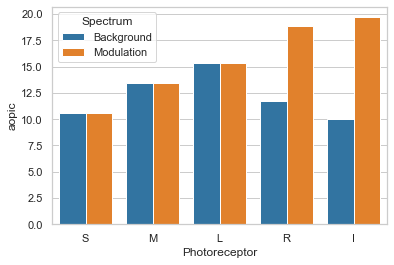

In [11]:
def plot_solution(background, modulation):
    df = (
        pd.concat([background, modulation], axis=1)
        .T.melt(
            value_name='aopic',
            var_name='Photoreceptor',
            ignore_index=False)
        .reset_index()
        .rename(
            columns={'index': 'Spectrum'})
         )
    sns.barplot(data=df, x='Photoreceptor', y='aopic', hue='Spectrum')
    
b, m = op.smlri_calculator(res.x)
plot_solution(b, m)